実装手順  
前準備  
1 wordsからsetを作る  
2 setを用いてruleを抽出  
3 word, prefix, suffixとidを対応させる  
4 prefix, suffixの数を数えて、係数ベクトルの行列を作っておく  
5 word1_id, suffix_id, prefix_id, word2_idの組を保存しておく←要らない？  
6 word1に対応するrule(word_id, prefix_id or suffix_id, is_suffix)を格納する  is_suffix=Bool 

forward  
1 入力word1
   word2はword1より長い必要がある  
2 word1, word2をベクトル化する  
3 word1_vec, prefix_vec or suffix_vecからword2_vec'を作成  
4 word2_vecとlossを計算  

備考  
ruleは変化系は含めない  
prefix, suffix共に最大長さ制限を入れる(デフォルトは4文字)  
語彙全体の8割をtrain, 1割をvalidate, 1割をtestに分ける  
word_vectorはtrain, validate, test全ての入力単語に対応する必要がある  
1. embeddingを定義
2. vocabをtrain, evaluate, testに分割  
3. **trainのvocabを用いてruleを抽出**(leakを防ぐ)、prefix, suffix, modelを作成  
4. 学習用に、train, validateから分割されない単語を取り除いたsetを作成
5. 学習、train, validate双方から単語をランダムに選ぶ  
6. 単語を分割しうる(word, prefix/suffix)のlistを作成  
7. trainの単語全てで学習を行う  
8. 評価はvalidateの各単語に対し、最も損失の少ない分割方法のlossを最小化する 
9. early stopping入れる？一旦入れずに損失の様子をみて判断  
10. testはlossにsoftmaxをかけて確率的に表現

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from random import sample
from collections import defaultdict
from pathlib import Path
import networkx as nx
import pickle
from itertools import permutations
import numpy as np
from random import sample
from gensim.models.keyedvectors import KeyedVectors
from gensim.similarities.index import AnnoyIndexer
from scipy.stats import spearmanr
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import unicodedata
import re

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [69]:
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

予め単語を綺麗にすると、embeddingに埋められない単語が出てくる  
埋められない奴は予め省いておく

# 単語の読み込み

In [4]:
%%time
embedding = KeyedVectors.load_word2vec_format('../input/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=10000)

CPU times: user 512 ms, sys: 4 ms, total: 516 ms
Wall time: 673 ms


In [5]:
# gensimのKeyedVectorsについて補足  
# embedding.vectorsに(単語数, 次元数)のベクトルが格納されている
print(embedding.vectors.shape)
# embedding['word']で単語に対応したベクトルを取り出すときは、
# 1. embedding.vocabの中にwordが入っているか確認
# 2. embedding.voacb[word].indexで単語に対応したindexを取り出す
# 3. embedding.vectors[index]で単語に対応する(次元数,)のベクトルを返す
# という作業を行なっている
# 参考URL(ソースコード, 266行目から271行目)
# https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/keyedvectors.py
# pytorchのモデルの中に組み込む事も出来るが、
# 先にword2tensor等の関数で、embeddingした単語ベクトルをモデルに入力する方が楽

(10000, 300)


In [6]:
embedding.vocab['that'].index

3

In [7]:
embedding.vectors.shape

(10000, 300)

In [8]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    
# 大文字を全部小文字にする
# 無駄な空白や文字じゃないやつを全部消す
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r"", s)
    return s

In [9]:
%%time
# あらかじめ入力する単語を綺麗にしておく
# 全て小文字にして、a-z以外の単語を取り除く
normalized_words = set([normalizeString(word) for word in embedding.vocab.keys()]) & embedding.vocab.keys()

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 113 ms


# 単語群をtrain, validate, testに分割

trainはモデルの学習に使う単語  
validateはモデルの学習と並行でforwardさせ、lossを計算するが、backwardは行わない  
trainのlossとvalidateのlossを比較し、過学習が起きないかを監視する単語  
testはモデルの最終的な評価に使う単語  

In [10]:
n_train = int(len(normalized_words) * 0.8)
n_validate = int(len(normalized_words) * 0.1)
n_test = len(normalized_words) - n_train - n_validate

all_words = list(normalized_words)
train_words = set(sample(all_words, n_train))
validate_words = set(sample(list(set(all_words) - train_words), n_validate))
test_words = normalized_words - train_words - validate_words

In [11]:
n_train, n_validate, n_test, len(normalized_words)

(5647, 705, 707, 7059)

In [12]:
print(len(train_words), len(validate_words), len(test_words))

5647 705 707


In [13]:
from copy import deepcopy

In [14]:
tmp = deepcopy(validate_words)

# prefixとsuffixの抽出

In [15]:
def extract_prefixes(words, max_len=6):
    # rules(dict) {add: [(word1, word2), (word3, word4), etc]}
    prefixes = defaultdict(list)
    for (word1, word2) in permutations(words, 2):
        if word2.endswith(word1):
            prefix = word2[:word2.rfind(word1)] # rfindは後ろから検索, 先頭検索はNG
            if len(prefix) <= max_len:
                prefixes[prefix].append((word1, word2))
    return dict(prefixes) # lock dict

In [16]:
def extract_suffixes(words, max_len=6):
    # rules(dict) {add: [(word1, word2), (word3, word4), etc]}
    suffixes = defaultdict(list)
    for (word1, word2) in permutations(words, 2):
        if word2.startswith(word1):
            suffix = word2[len(word1):]
            if len(suffix) <= max_len:
                suffixes[suffix].append((word1, word2))
    return dict(suffixes) # lock dict

In [17]:
%%time
prefixes = extract_prefixes(train_words, max_len=4)

CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 15 s


In [18]:
%%time
suffixes = extract_suffixes(train_words, max_len=4)

CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 14.2 s


In [19]:
len(prefixes), len(suffixes), len(train_words)

(1306, 1104, 5647)

prefix, suffixとして抽出可能な最大長さを6→4にすると、大体半減する  

In [20]:
prefixes['dis']

[('appointment', 'disappointment'),
 ('miss', 'dismiss'),
 ('plays', 'displays'),
 ('tribute', 'distribute'),
 ('appointed', 'disappointed'),
 ('ability', 'disability'),
 ('missed', 'dismissed'),
 ('closed', 'disclosed'),
 ('appear', 'disappear'),
 ('agree', 'disagree'),
 ('ease', 'disease'),
 ('close', 'disclose'),
 ('appearance', 'disappearance'),
 ('count', 'discount'),
 ('c', 'disc'),
 ('cover', 'discover'),
 ('placed', 'displaced')]

# Ruleとして格納

In [21]:
# prefix, suffixでクラスを分けようかと思ったけど、wordは共通して処理する必要があるので合体させる
class Rules:
    def __init__(self):
        self.n_words = 0
        self.n_prefixes = 0
        self.n_suffixes = 0
        self.word2count = defaultdict(int)
        self.prefix2count = defaultdict(int)
        self.suffix2count = defaultdict(int)
        self.word2index = defaultdict(int)
        self.prefix2index = defaultdict(int)
        self.suffix2index = defaultdict(int)
        self.index2word = defaultdict(str)
        self.index2prefix = defaultdict(str)
        self.index2suffix = defaultdict(str)
        self.word2prefixes = defaultdict(list) # key: word2, value: (prefix, word1)
        self.word2suffixes = defaultdict(list) # key: word2, value: (suffix, word1)
        
    def add_prefix(self, prefix, pairs):
        # store words
        for word in pairs:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.word2count[word] = 1
                self.n_words += 1
            else:
                self.word2count[word] += 1
        # store prefix
        if prefix not in self.prefix2index:
            self.prefix2index[prefix] = self.n_prefixes
            self.index2prefix[self.n_prefixes] = prefix
            self.prefix2count[prefix] = 1
            self.n_prefixes += 1
        else:
            self.prefix2count[prefix] += 1
        
        self.word2prefixes[pairs[1]].append((prefix, pairs[0]))
        
    
    def add_prefixes(self, prefixes):
        for prefix, pairs in prefixes.items():
            for pair in pairs:
                self.add_prefix(prefix, pair)

    def add_suffix(self, suffix, pairs):
        # store words
        for word in pairs:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.word2count[word] = 1
                self.n_words += 1
            else:
                self.word2count[word] += 1
        # store suffix
        if suffix not in self.suffix2index:
            self.suffix2index[suffix] = self.n_suffixes
            self.index2suffix[self.n_suffixes] = suffix
            self.suffix2count[suffix] = 1
            self.n_suffixes += 1
        else:
            self.suffix2count[suffix] += 1
        
        self.word2suffixes[pairs[1]].append((suffix, pairs[0]))
        
    
    def add_suffixes(self, suffixes):
        for suffix, pairs in suffixes.items():
            for pair in pairs:
                self.add_suffix(suffix, pair)
    
    def as_normal_dict(self):
        # defaultdictは、存在しないkeyを参照すると自動的にvalueを生成する
        # defaultdict(int)なら0を、defaultdict(list)なら[]を生成
        # すると、index系が崩れてしまうので、通常のdictに変換する
        self.word2count = dict(self.word2count)
        self.prefix2count = dict(self.prefix2index)
        self.suffix2count = dict(self.suffix2count)
        self.word2index = dict(self.word2index)
        self.prefix2index = dict(self.prefix2index)
        self.suffix2index = dict(self.suffix2index)
        self.index2word = dict(self.index2word)
        self.index2prefix = dict(self.index2prefix)
        self.index2suffix = dict(self.index2suffix)
        self.word2prefixes = dict(self.word2prefixes)
        self.word2suffixes = dict(self.word2suffixes)

In [22]:
rules = Rules()

In [23]:
%%time
rules.add_prefixes(prefixes)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 15 ms


In [24]:
%%time
rules.add_suffixes(suffixes)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 18.3 ms


In [25]:
# これ以上ruleを加えないなら、dictをlockする
# lockする前は、存在しないkeyを参照すると自動的に空のvalueが生成される
# lockすると、存在しないkeyを参照するとerrorを起こすようになる
rules.as_normal_dict()

In [26]:
len(prefixes), len(suffixes), len(train_words)

(1306, 1104, 5647)

In [27]:
rules.n_prefixes, rules.n_suffixes, rules.n_words

(1306, 1104, 4394)

# validate, test_wordsをrulesに格納

詳細は後述  
Rules.word2suffixes, Rules.word2prefixesに, validate, test_wordsを格納していく  
word2を、全てのword1, prefix/suffixを用いて分割出来ないか全探索する  

In [29]:
# 並列処理させないとしんどい
def try_pref_splits(word2):
    candidates = list()
    for pref in rules.prefix2index.keys():
        if not word2.startswith(pref): # wordがprefixで始まっていなかったら
            continue # ループの先頭に戻る
        else:
            root = word2[len(pref):]
            for word1 in rules.word2index.keys():
                if root == word1:
                    candidates.append((pref, word1))
    if len(candidates) >= 1:
        return {word2: candidates}
        
def try_suf_splits(word2):
    candidates = list()
    for suf in rules.suffix2index.keys():
        if not word2.startswith(suf): # wordがsuffixで始まっていなかったら
            continue # ループの先頭に戻る
        else:
            root = word2[len(suf):]
            for word1 in rules.word2index.keys():
                if root == word1:
                    candidates.append((suf, word1))
    if len(candidates) >= 1:
        return {word2: candidates}

def load_val_w_parallel(val_words):
    p = Pool()
    pref_dicts = p.map(try_pref_splits, val_words)
    [rules.word2prefixes.update(dict_) for dict_ in pref_dicts if dict_ is not None]
    
    suf_dicts = p.map(try_suf_splits, val_words)
    [rules.word2suffixes.update(dict_) for dict_ in suf_dicts if dict_ is not None]

In [30]:
load_val_w_parallel(validate_words)

Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/mul

In [31]:
load_val_w_parallel(test_words)

Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36

# RuleからTensorに変換

In [32]:
def tensor_from_word(word):
    return torch.from_numpy(embedding[word]).view(1, -1).to(device)

In [33]:
def tensors_from_pair(pair):
    input_tensor = tensor_from_word(pair[0])
    target_tensor = tensor_from_word(pair[1])
    return input_tensor, target_tensor

In [34]:
def tensor_from_prefix(prefix):
    idx = rules.prefix2index[prefix]
    output = torch.LongTensor([idx]).to(device)
    return output

In [35]:
def tensor_from_suffix(suffix):
    idx = rules.suffix2index[suffix]
    output = torch.LongTensor([idx]).to(device)
    return output

In [36]:
sum(tensor_from_prefix('dis'))

tensor(167, device='cuda:0')

# 単語から分割候補を抽出

In [37]:
def get_candidate_prefixes(word):
    ''' 単語を入力すると語頭分割候補を返す、rulesを予め作成する必要あり'''
    try:
        prefixes = rules.word2prefixes[word]
    except: # エラーが発生した場合(ここでは対応するvalueが無い事を想定)
        return False
    else: # 分割候補が帰ってきた場合
        return prefixes

In [38]:
def get_candidate_suffixes(word):
    ''' 単語を入力すると語頭分割候補を返す、rulesを予め作成する必要あり'''
    try:
        suffixes = rules.word2suffixes[word]
    except: # エラーが発生した場合(ここでは対応するvalueが無い事を想定)
        return False
    else: # 分割候補が帰ってきた場合
        return suffixes

In [39]:
# 使用例
print('six' in normalized_words) # embeddingに入っているかチェック
print(get_candidate_prefixes('six')) # prefixで分割する候補を調べる
print(prefixes['si']) # 分割手法が見つかったので、同様の手法が適用出来る文字を調べる

print('')

print('sell' in normalized_words) # embeddingに入っているかチェック
print(get_candidate_prefixes('sell')) # 分割する候補が無い場合の挙動

True
[('si', 'x')]
[('x', 'six'), ('t', 'sit')]

True
False


In [40]:
def candidate_prefix_tensors_from_word(word):
    prefixes = get_candidate_prefixes(word)
    if prefixes is False:
        print('分割候補がありません')
        return False
    else:
        candidates = list()
        for c in prefixes:
            prefix_tensor = tensor_from_prefix(c[0])
            word_tensor = tensor_from_word(c[1])
            candidates.append((prefix_tensor, word_tensor))
        return candidates

In [41]:
def candidate_suffix_tensors_from_word(word):
    suffixes = get_candidate_suffixes(word)
    if suffixes is False:
        print('分割候補がありません')
        return False
    else:
        candidates = list()
        for c in suffixes:
            suffix_tensor = tensor_from_suffix(c[0])
            word_tensor = tensor_from_word(c[1])
            candidates.append((suffix_tensor, word_tensor))
        return candidates

In [42]:
# 使用例
print("全分割候補: {}".format(get_candidate_suffixes('users')))
candidates = candidate_suffix_tensors_from_word('users')
print("1つ目の候補のsuffixベクトルの型: {}".format(candidates[0][0].shape))
print("1つ目の候補のwordベクトルの型: {}".format(candidates[0][1].shape))
print("分割候補数: {}".format(len(candidates)))

全分割候補: [('s', 'user'), ('rs', 'use'), ('ers', 'us')]
1つ目の候補のsuffixベクトルの型: torch.Size([1])
1つ目の候補のwordベクトルの型: torch.Size([1, 300])
分割候補数: 3


# 分割可能なtrain, validate, test_wordsを選別

モデルの学習を行えるのは、学習・評価データに含まれる単語が分割可能な場合  
単語が分割不可能な場合、入力に用いるprefix/suffixを準備出来ない  
分割可能な単語群を、予め選別しておく  
train_wordsは既に作成したruleを使えば良いが、validate, test_wordsに関しては  
train_wordsとprefixes, suffixを使って分割出来ないか全検索する必要がある

ここがややこしいので補足しておく  
validation_words, test_wordsをtest_wordsと一緒にすると、leakを起こす  
leakとは、学習用データのみを用いてモデルを構築する必要があるのに、  
評価用データが混入する事をさす  
評価用データに対して精度は向上するが、未知のデータに対する精度が下がる=過学習  

train_wordsは全ての(word1, word2)の組み合わせからsuffix/prefixを探したが、  
validate_words, test_wordsは既知のtrain_words, prefix/suffixを組み合わせて  
分割を行えないか全検索する  


モデルの学習の観点からこの操作を説明する  
分割を行いたい単語をword2, 分割された後の単語をword1とする  
prefix + word1 = word2  or word1 + suffix = word2  

モデルの入出力は  
modelのinput: word1_vector, prefix/suffix_vector  
modelのoutput: word2'_vector(予測)  
modelのtarget: words_vector(実測)  
となる  

ここで、modelはtrain_wordのみを用いて学習させる必要があるので、入力である  
word1_vector, prefix/suffix_vectorはtrain_wordsのみから学習させる必要がある  
一方で、modelのtargetは学習データを用いるので、  
word2_vectorはvalidation_words, test_wordsを利用する  
従って、モデルのvalidation, testを行いたい場合は以下の手順で評価データを準備する  
1. train_wordsから作成したword1_vector, prefix/suffix_vectorを準備
2. validation_words, test_wordsを1で準備したベクトルで再現出来ないか試す
3. 再現出来た場合、input: word1, prefix/suffix, target: word2というペアが出来る  
4. 再現出来なかった場合、その単語は捨てる(今回のモデルでは分割ナシという判断)  
5. こうして準備したvalidation_words, test_wordsでモデルの評価を行う  

**実際の処理では、rulesを作成した時に予め1-3の処理を行なっておく**  
そのため、Rules.word2suffixes, Rule.word2prefixesのkey(上の例でいうword2に相当)  
にはvalidation_words, test_wordsが含まれている  
もちろん、valueである(suffix/prefix, word1)にvalidationやtestの情報は含まれていない

In [48]:
class Data:
    def __init__(self):
        self.pref_train_words = set()
        self.pref_validate_words = set()
        self.pref_test_words = set()
        self.suf_train_words = set()
        self.suf_validate_words = set()
        self.suf_test_words = set()
        self.n_pref_train_words = 0
        self.n_pref_validate_words = 0
        self.n_pref_test_words = 0
        self.n_suf_train_words = 0
        self.n_suf_validate_words = 0
        self.n_suf_test_words = 0
    
    def load_words(self, train_words, validate_words, test_words):
        # preffixで分割可能なwordを格納
        [self.pref_train_words.add(word) for word in train_words\
             if get_candidate_prefixes(word) is not False]
        [self.pref_validate_words.add(word) for word in validate_words\
             if get_candidate_prefixes(word) is not False]
        [self.pref_test_words.add(word) for word in test_words\
             if get_candidate_prefixes(word) is not False]
        
        # suffixで分割可能なwordを格納
        [self.suf_train_words.add(word) for word in train_words\
            if get_candidate_suffixes(word) is not False]
        [self.suf_validate_words.add(word) for word in validate_words\
            if get_candidate_suffixes(word) is not False]
        [self.suf_test_words.add(word) for word in test_words\
            if get_candidate_suffixes(word) is not False]
        
        # 各単語数を格納
        self.n_pref_train_words = len(self.pref_train_words)
        self.n_pref_validate_words = len(self.pref_validate_words)
        self.n_pref_test_words = len(self.pref_test_words)
        self.n_suf_train_words = len(self.suf_train_words)
        self.n_suf_validate_words = len(self.suf_validate_words)
        self.n_suf_test_words = len(self.suf_test_words)

In [49]:
data = Data()
data.load_words(train_words, validate_words, test_words)

In [50]:
len(train_words), len(validate_words), len(test_words)

(5647, 705, 707)

In [56]:
# prefixの場合、分割可能なtrain単語は4割弱
print('train分割可能割合: {:.2f}%'.format(
    data.n_pref_train_words / len(train_words)*100))

# validate
print('validate分割可能割合: {:.2f}%'.format(
    data.n_pref_validate_words / len(validate_words)*100))

# test
print('test分割可能割合: {:.2f}%'.format(
    data.n_pref_test_words / len(test_words)*100))

train分割可能割合: 35.24%
validate分割可能割合: 21.13%
test分割可能割合: 19.66%


trainの情報を元にvalidation, testを分割しているので、分割可能割合は下がる  

# モデルの作成

In [57]:
class PrefixEmbedding(nn.Module):
    def __init__(self, word_size, prefix_size, hidden_size, output_size):
        super(PrefixEmbedding, self).__init__()
        self.word_size = word_size
        self.prefix_size = prefix_size
        self.hidden_size = hidden_size # prefix_embeddingのoutput_sizeと同義
        self.output_size = output_size # output_size == input_sizeになる
        
        self.pref_emb = nn.Embedding(self.prefix_size, self.hidden_size)
        self.affine = nn.Linear(word_size + hidden_size, output_size)

    def forward(self, word, prefix):
        hidden = self.pref_emb(prefix)
        combined = torch.cat((word, hidden), 1)
        output = self.affine(combined)
        return output

In [58]:
prefix_size = rules.n_prefixes
hidden_size = 100
word_size = output_size = embedding.vector_size

In [59]:
prefix_embedding = PrefixEmbedding(word_size, prefix_size, hidden_size, output_size).to(device)

# モデルの学習

In [60]:
def train(word_tensor, prefix_tensor, target_tensor, 
          model, optimizer, criterion):
    
    optimizer.zero_grad() # 学習関数の初期値をリセット
    
    loss = 0
    
    output_tensor = prefix_embedding(word_tensor, prefix_tensor)
    loss += criterion(output_tensor, target_tensor)
    
    loss.backward()
    optimizer.step()
    
    return loss

In [61]:
def validate(word_tensor, prefix_tensor, target_tensor, model, criterion):
    with torch.no_grad():
        output_tensor = prefix_embedding(word_tensor, prefix_tensor)
        loss = criterion(output_tensor, target_tensor)
    return loss

In [65]:
# 超パラメータの設定
learning_rate = 0.01
n_iters = 100
print_every = 10

In [66]:
# prefixの学習
optimizer = optim.Adam(prefix_embedding.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
train_learning_curve = []
validate_learning_curve = []

for epoch in tqdm(range(n_iters)):
    
    train_loss_per_epoch = 0
    val_loss_per_epoch = 0
    # training mode
    for tw in data.pref_train_words:
        loss_per_tw = 0
        target_tensor = tensor_from_word(tw)
        candidates = candidate_prefix_tensors_from_word(tw)
        for candidate in candidates:
            prefix_tensor = candidate[0]
            word_tensor = candidate[1]
            loss = train(word_tensor, prefix_tensor, target_tensor,
                         prefix_embedding, optimizer, criterion)
            # 将来的には、最もlossが低い分割手法のlossのみをbackwardする
            loss_per_tw += loss
        loss_per_tw = loss_per_tw / len(candidates)
        train_loss_per_epoch += loss_per_tw
        
    train_loss_per_epoch = train_loss_per_epoch / data.n_pref_train_words
    train_learning_curve.append(train_loss_per_epoch)
        
    # validation mode
    for vw in data.pref_validate_words:
        loss_per_vw = list()
        target_tensor = tensor_from_word(vw)
        candidates = candidate_prefix_tensors_from_word(vw)
        for candidate in candidates:
            prefix_tensor = candidate[0]
            word_tensor = candidate[1]
            loss =  validate(word_tensor, prefix_tensor, target_tensor,
                           prefix_embedding, criterion)
            loss_per_vw.append(loss) # 最もlossが低い分割手法のlossのみを監視する
        loss_per_vw = max(loss_per_vw)
        val_loss_per_epoch += loss_per_vw
    
    val_loss_per_epoch = val_loss_per_epoch / data.n_pref_validate_words
    validate_learning_curve.append(val_loss_per_epoch)
    
    if epoch % print_every == 0:
        print('iter: {}, train_loss:{:.3f}, validate_loss:{:.3f}'.format(
            epoch, train_loss_per_epoch, val_loss_per_epoch))

iter: 0, train_loss:0.287, validate_loss:0.286
iter: 10, train_loss:0.256, validate_loss:0.323
iter: 20, train_loss:0.242, validate_loss:0.288
iter: 30, train_loss:0.244, validate_loss:0.306
iter: 40, train_loss:0.238, validate_loss:0.368
iter: 50, train_loss:0.245, validate_loss:0.355
iter: 60, train_loss:0.234, validate_loss:0.342
iter: 70, train_loss:0.243, validate_loss:0.338
iter: 80, train_loss:0.252, validate_loss:0.367
iter: 90, train_loss:0.253, validate_loss:0.433


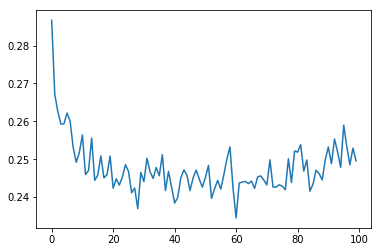

In [70]:
plt.plot(train_learning_curve)

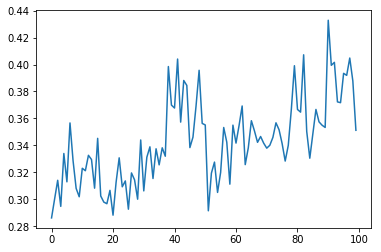

In [71]:
plt.plot(validate_learning_curve)

ダメダメ